In [174]:
import pandas as pd
import numpy as np
import wget
from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from tqdm.auto import tqdm

In [175]:
data_url = 'https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv'
filename = wget.download(data_url)

In [176]:
data_full = pd.read_csv('data.csv')

## Data Preparation

In [177]:
data = data_full[['Make','Model','Year','Engine HP','Engine Cylinders','Transmission Type',
   'Vehicle Style','highway MPG','city mpg','MSRP']]

In [178]:
data.columns = data.columns.str.replace(' ', '_').str.lower()
data.isnull().sum()

make                  0
model                 0
year                  0
engine_hp            69
engine_cylinders     30
transmission_type     0
vehicle_style         0
highway_mpg           0
city_mpg              0
msrp                  0
dtype: int64

In [179]:
df = data.copy()
df['engine_hp'] = df['engine_hp'].fillna(0)
df['engine_cylinders'] = df['engine_cylinders'].fillna(0)
df = df.rename(columns={"msrp": "price"})
avg_price = df['price'].mean()
df['above_average'] = (df['price'] > avg_price).astype(int)

In [180]:
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=42)
y_train = df_train.above_average.values
y_val = df_val.above_average.values
y_test = df_test.above_average.values
del df_train['above_average']
del df_train['price']
del df_val['above_average']
del df_val['price']
del df_test['above_average']
del df_test['price']

## Q1

In [68]:
df_train

,make,model,year,engine_hp,engine_cylinders,transmission_type,vehicle_style,highway_mpg,city_mpg
3972,Mitsubishi,Endeavor,2011,225.0,6.0,AUTOMATIC,4dr SUV,19,15
1997,Kia,Borrego,2009,276.0,6.0,AUTOMATIC,4dr SUV,21,17
5216,Lamborghini,Gallardo,2012,570.0,10.0,MANUAL,Convertible,20,12
2805,Chevrolet,Colorado,2016,200.0,4.0,AUTOMATIC,Crew Cab Pickup,27,20
11369,Pontiac,Vibe,2009,158.0,4.0,AUTOMATIC,4dr Hatchback,26,20
...,...,...,...,...,...,...,...,...,...
9232,Toyota,Sienna,2016,266.0,6.0,AUTOMATIC,Passenger Minivan,25,18
5710,Chevrolet,HHR,2009,260.0,4.0,MANUAL,Wagon,29,21
11306,Hyundai,Veracruz,2012,260.0,6.0,AUTOMATIC,4dr SUV,22,17
4414,Mitsubishi,Expo,1993,136.0,4.0,MANUAL,2dr Hatchback,26,19


In [24]:
y_train

array([0, 0, 1, ..., 0, 0, 0])

In [25]:
df['year'].values

array([2011, 2011, 2011, ..., 2012, 2013, 2006], dtype=int64)

In [54]:
numeric_features = ['year', 'engine_hp', 'engine_cylinders','highway_mpg','city_mpg']
for feature in numeric_features:
    fpr = 0
    tpr = 0
    thresholds = 0
    feature_auc = 0
    fpr, tpr, thresholds = roc_curve(y_train, df_train[feature].values) ## replace <0.5 numbers
    feature_auc = auc(fpr,tpr)
    print("For feature: " + feature + " AUC is " + str(round(feature_auc,2)))

For feature: year AUC is 0.69
For feature: engine_hp AUC is 0.91
For feature: engine_cylinders AUC is 0.77
For feature: highway_mpg AUC is 0.37
For feature: city_mpg AUC is 0.33


## Q2

In [87]:
train_dict = df_train.to_dict(orient='records')
dv = DictVectorizer(sparse=False)
dv.fit(train_dict)
X_train = dv.transform(train_dict)
X_train.shape
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')

In [88]:
val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)
y_pred_proba = model.predict_proba(X_val)[:, 1]
y_pred = model.predict(X_val)

In [89]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
fpr_proba, tpr_proba, thresholds_proba = roc_curve(y_val, y_pred_proba)
print("Proba: " + str(round(auc(fpr_proba,tpr_proba),3)))
print("Prob: " + str(round(auc(fpr,tpr),3)))

Proba: 0.984
Prob: 0.93


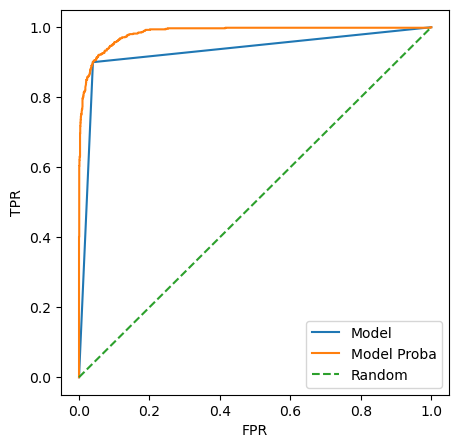

In [90]:
plt.figure(figsize=(5, 5))

plt.plot(fpr, tpr, label='Model')
plt.plot(fpr_proba, tpr_proba, label='Model Proba')
plt.plot([0, 1], [0, 1], label='Random', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

## Q3

In [93]:
def scores_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)

    df_scores['tpr (recall)'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)
    
    df_scores['precision'] = df_scores.tp / (df_scores.tp + df_scores.fp)
    df_scores['recall'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    
    return df_scores

In [96]:
scores = scores_dataframe(y_val, y_pred_proba)
scores

,threshold,tp,fp,fn,tn,tpr (recall),fpr,precision,recall
0,0.00,661,1722,0,0,1.000000,1.000000,0.277381,1.000000
1,0.01,660,761,1,961,0.998487,0.441928,0.464462,0.998487
2,0.02,659,632,2,1090,0.996974,0.367015,0.510457,0.996974
3,0.03,659,554,2,1168,0.996974,0.321719,0.543281,0.996974
4,0.04,659,491,2,1231,0.996974,0.285134,0.573043,0.996974
...,...,...,...,...,...,...,...,...,...
96,0.96,275,1,386,1721,0.416036,0.000581,0.996377,0.416036
97,0.97,251,0,410,1722,0.379728,0.000000,1.000000,0.379728
98,0.98,219,0,442,1722,0.331316,0.000000,1.000000,0.331316
99,0.99,182,0,479,1722,0.275340,0.000000,1.000000,0.275340


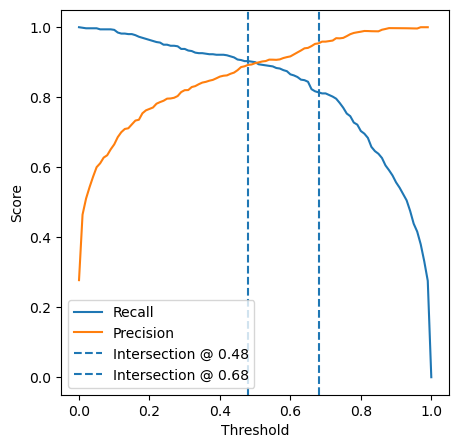

In [109]:
plt.figure(figsize=(5, 5))

plt.plot(scores['threshold'], scores['recall'],label='Recall')
plt.plot(scores['threshold'], scores['precision'],label='Precision')
plt.axvline(x=0.48, label='Intersection @ 0.48', linestyle='--')
plt.axvline(x=0.68, label='Intersection @ 0.68', linestyle='--')

plt.xlabel('Threshold')
plt.ylabel('Score')

plt.legend()

In [101]:
scores[scores['threshold'] == 0.48]

,threshold,tp,fp,fn,tn,tpr (recall),fpr,precision,recall
68,0.68,538,26,123,1696,0.813918,0.015099,0.953901,0.813918


## Q4

In [110]:
def scores_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)

    df_scores['tpr (recall)'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)
    
    df_scores['precision'] = df_scores.tp / (df_scores.tp + df_scores.fp)
    df_scores['recall'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['f1'] = 2 * ((df_scores.precision * df_scores.recall) / (df_scores.precision + df_scores.recall))
    
    return df_scores

In [111]:
scores = scores_dataframe(y_val, y_pred_proba)
scores

,threshold,tp,fp,fn,tn,tpr (recall),fpr,precision,recall,f1
0,0.00,661,1722,0,0,1.000000,1.000000,0.277381,1.000000,0.434297
1,0.01,660,761,1,961,0.998487,0.441928,0.464462,0.998487,0.634006
2,0.02,659,632,2,1090,0.996974,0.367015,0.510457,0.996974,0.675205
3,0.03,659,554,2,1168,0.996974,0.321719,0.543281,0.996974,0.703308
4,0.04,659,491,2,1231,0.996974,0.285134,0.573043,0.996974,0.727775
...,...,...,...,...,...,...,...,...,...,...
96,0.96,275,1,386,1721,0.416036,0.000581,0.996377,0.416036,0.586980
97,0.97,251,0,410,1722,0.379728,0.000000,1.000000,0.379728,0.550439
98,0.98,219,0,442,1722,0.331316,0.000000,1.000000,0.331316,0.497727
99,0.99,182,0,479,1722,0.275340,0.000000,1.000000,0.275340,0.431791


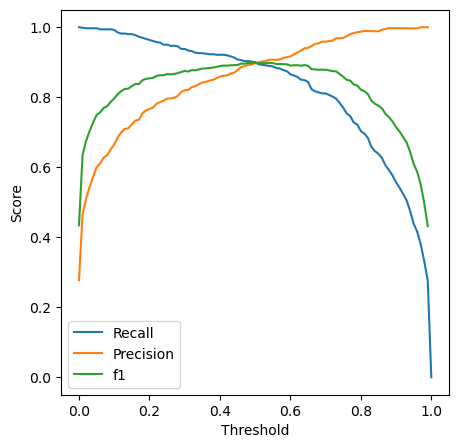

In [112]:
plt.figure(figsize=(5, 5))

plt.plot(scores['threshold'], scores['recall'],label='Recall')
plt.plot(scores['threshold'], scores['precision'],label='Precision')
plt.plot(scores['threshold'], scores['f1'],label='f1')

plt.xlabel('Threshold')
plt.ylabel('Score')

plt.legend()

In [113]:
max(scores['f1'].values)

0.8987915407854985

In [116]:
df = scores.sort_values(by='f1', ascending=False)

# Get the threshold corresponding to the maximum F1 score (the first row after sorting)
best_threshold = df.iloc[0]['threshold']
best_f1_score = df.iloc[0]['f1']

best_threshold
#best_f1_score

0.5

## Q5

In [183]:
def train(df_train, feature_list, y_train, C=1.0):
    dicts = df_train[feature_list].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear',C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [184]:
def predict(df, feature_list, dv, model):
    dicts = df[feature_list].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [185]:
def compute_auc_k_fold(df_full_train, feature_list, n_splits, C):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)
    scores = []
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.above_average.values
        y_val = df_val.above_average.values

        dv, model = train(df_train, feature_list, y_train, C=C)
        y_pred = predict(df_val, feature_list, dv, model)

        fpr, tpr, thresholds = roc_curve(y_val, y_pred)
        scores.append(auc(fpr,tpr))
        
    return scores

In [186]:
feature_list = df_train.columns
scores = compute_auc_k_fold(df_train_full, feature_list, 5, 1.0)

In [187]:
np.std(scores)

0.0030234773265371746

In [189]:
scores

[0.9739739331778645,
 0.9831805519564654,
 0.9805197612784063,
 0.97845623000404,
 0.9797104919085686]

## Q6

In [190]:
n_splits = 5

for C in tqdm([0.01, 0.1, 0.5, 10]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)
    scores = []
    scores = compute_auc_k_fold(df_train_full, feature_list, n_splits, C)
    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/4 [00:00<?, ?it/s]

C=0.01 0.951 +- 0.006
C=0.1 0.970 +- 0.004
C=0.5 0.977 +- 0.005
C=10 0.979 +- 0.005
